# Tutorial 4: Shutter corrections

### Further reading:

* Previoius tutorials
* PL slides



# Load the packages

In [2]:
# Support Posix paths. Takes care of OS specific paths.
from pathlib import Path

# The usual libs
import numpy as np
import matplotlib.pyplot as plt

# Astropy
# The tools in ccdproc accept only CCDData objects
from astropy.nddata import CCDData

from astropy.stats import mad_std
from astropy.modeling import models

#ccdproc
import ccdproc as ccdp
from ccdproc import ImageFileCollection



## Read the data

In [3]:
read_path = Path('shutter')
write_path = Path('proc_shutter')
write_path.mkdir(exist_ok=True)  # create the directory if it doesn't exist

#Make an image file collection for the raw data
imcol = ImageFileCollection(read_path)  

# This example uses the Zero image from a previous tutorial.  
# Use the superZero image from your PL report instead
zero_path = Path('proc')
Zero = CCDData.read(zero_path / 'Zero.fits')

#imcol.summary.colnames 
#imcol.summary['file']
#imcol.summary['file', 'imagetyp', 'object', 'filter', 'exptime']
#list_flatI = imcol.files_filtered(filter='I', imagetyp='FLAT')
#imcol_flatI = imcol.filter(filter='I', imagetyp='FLAT')

In [4]:
# Check the header kewords
imcol.summary.colnames

['file',
 'simple',
 'bitpix',
 'naxis',
 'naxis1',
 'naxis2',
 'extend',
 'bscale',
 'bzero',
 'date',
 'iraf-tlm',
 'origin']

## identify the 20x1s and the 1x20s sets

In [5]:
for ccd, file_name in imcol.ccds(ccd_kwargs={'unit': 'adu'},
                                 return_fname=True 
                                ):    
    print(file_name, ccd.data[100:200,100:200].mean())


shutm1.fits 46540.2368
shutm2.fits 46051.6572
shutm3.fits 45735.0387
shutm4.fits 45528.9382
shutm5.fits 45291.1284
shutm6.fits 45085.9893
shutt1.fits 45621.403
shutt2.fits 45275.7083
shutt3.fits 44938.3289
shutt4.fits 44863.5466
shutt5.fits 44762.8711
shutt6.fits 44672.6663


## Preprocess: overscan, trim, bias corrections 

In [6]:
for ccd, file_name in imcol.ccds(ccd_kwargs={'unit': 'adu'}, # CCDData requires a unit 
                                                             # it is not in the header
                                 return_fname=True           # Provide the file name too.
                                ):
    # Subtract the overscan
    poly_model = models.Polynomial1D(0)
    ccd = ccdp.subtract_overscan(ccd, fits_section='[1030:1068,:]', 
                                 model=poly_model, overscan_axis=1)

    # Trim the overscan
    ccd = ccdp.trim_image(ccd, fits_section='[1:1024, 1:1024]')
    
    # Subtract the bias
    ccd = ccdp.subtract_bias(ccd, Zero)
    ccd.header['zerocor'] = 'Zero.fits'
    
    
    # Save the result
    ccd.write(str(write_path)+'/OTZ_'+file_name, overwrite=True)

## Create the shutter correction image

In [8]:
# example from the shutm1, shutt1 pair
# do for all pairs
shutm = CCDData.read(write_path / 'OTZ_shutm1.fits')
shutt = CCDData.read(write_path / 'OTZ_shutt1.fits')

# The CCDData way
R = CCDData.divide(shutm,shutt)
aux1 = CCDData.subtract(R,1)
aux1 = CCDData.multiply(aux1, 20)
aux2 = CCDData.subtract(20,R)
delta = CCDData.divide(aux1,aux2)

#update header
delta.header['imagetyp'] = 'shutter'

# write to disk
delta.write(str(write_path)+'/delta_1.fits', overwrite=True) 

# or the numpy way
# R = shutm/shutt won't work here because
# CCDData class will complain if you divide images using the "/" operator
# R = np.divide(shutm,shutt)
# delta = (20*(R-1))/(20 - R)
# trickier but not hard: update header and write to disk


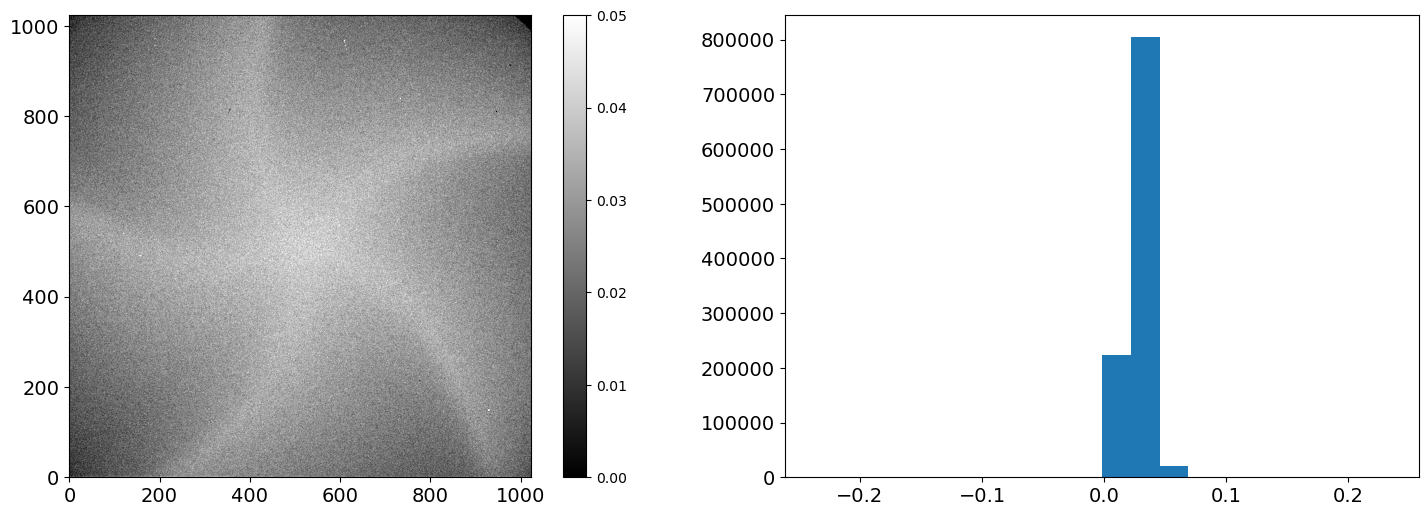

In [18]:
# display and adjust the scale

nrow=1
ncol=2
fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot(nrow,ncol,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.imshow(delta, cmap='gray', origin='lower', vmin=0, vmax=0.05)
plt.colorbar()

ax = fig.add_subplot(nrow,ncol,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
histogram = plt.hist(delta.data.flat, 20)




## Combine the shutter images: average with rejection

Full documentation on the combine function: https://ccdproc.readthedocs.io/en/latest/api/ccdproc.combine.html#ccdproc.combine

In [12]:
# In this example we'll average combine the bias images we have just processed
delta_images = ImageFileCollection(write_path, glob_include='delta_*')
#reduced_images.summary['file', 'imagetyp', 'object', 'filter', 'exptime']
list_delta = delta_images.files_filtered(imagetyp='shutter',include_path=True)
list_delta

['proc_shutter/delta_1.fits']

In [16]:
# The list of shutter images has only one element. 
# For this to be effective you need more
Delta = ccdp.combine(list_delta,
                             method='average',
                             sigma_clip=True, 
                             sigma_clip_low_thresh=5, 
                             sigma_clip_high_thresh=5, 
                             sigma_clip_func=np.ma.median, 
                             sigma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

Delta.meta['combined'] = 'average'

Delta.write(write_path / 'Delta_avg_1.fits', overwrite=True)

## Reducing noise: filter/smooth combined shutter image.

From the https://ccdproc.readthedocs.io/en/latest/reduction_toolbox.html#median-filter
    
There are several convolution and filter functions for numpy.ndarray across the scientific python packages:
* scipy.ndimage.filters, offers a variety of filters.
* astropy.convolution, offers some filters which also handle NaN values.
* scikit-image.filters, offers several filters which can also handle masks but are mostly limited to special data types (mostly unsigned integers).

For convenience one of these is also accessible through the ccdproc package namespace which accepts CCDData objects and then also returns one: median_filter

The median filter is especially useful if the data contains sharp noise peaks which should be removed rather than propagated:

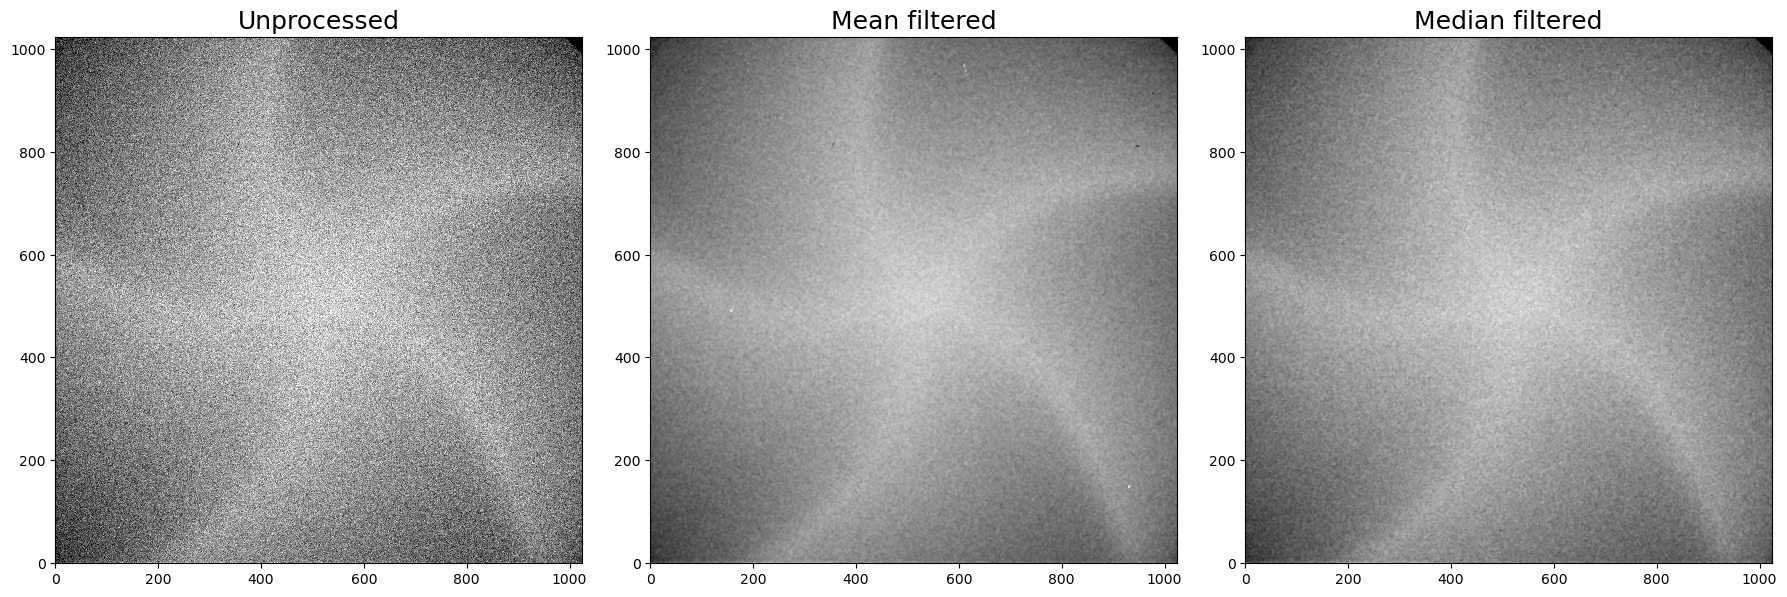

In [14]:
# import mean filter
from scipy.ndimage import uniform_filter

# Create some plots
nrow=1
ncol=3
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(nrow,ncol,1)
ax1.set_title('Unprocessed', fontsize = 18)
ax1.imshow(Delta, origin='lower', 
           interpolation='none', cmap=plt.cm.gray, vmin = 0, vmax = 0.05)
ax2 = fig.add_subplot(nrow,ncol,2)
ax2.set_title('Mean filtered', fontsize = 18)
ax2.imshow(uniform_filter(Delta.data, 5), 
           origin='lower', interpolation='none', cmap=plt.cm.gray, vmin = 0, vmax = 0.05)
ax3 = fig.add_subplot(nrow,ncol,3)
ax3.set_title('Median filtered', fontsize = 18)
ax3.imshow(ccdp.median_filter(Delta, 5), 
           origin='lower', interpolation='none', cmap=plt.cm.gray, vmin = 0, vmax = 0.05)
plt.tight_layout()
plt.show()

In [15]:
# Now compare the noise in each image.
# explore other filter box sizes and filters \
# Use a smaller section to avoid edges and spurious high counts

# Print statistics
print('Unprocessed:', Delta.data[500:505,500:505].std())

# Plots some cuts, etc


Unprocessed: 0.0058623161775255


#### How would you use your shutter correction image to actually correct images. To which images would you apply the corrections?
Try below